In [1]:
%matplotlib inline

0 of 132
Patient-id: 35939665
left


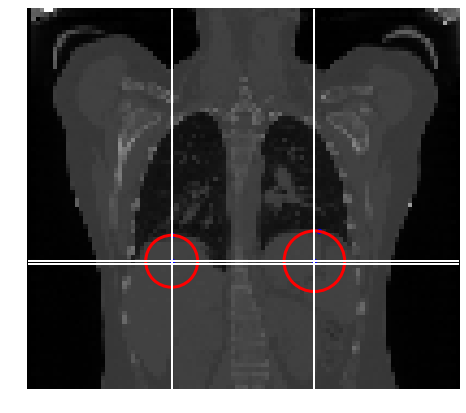

In [29]:
#%%writefile segmentation_3D_secondversion.py 

from segmentation_functions import resample, grow
from automaticSeeding_second_Version import find_seed
from .finding_biggest_lung import arrange_slices, normalization, get_pixels_hu
from seed_evaluation import evaluate_seed
import scipy.ndimage.interpolation as inter
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.io as spio
import pydicom
import time
#from PIL import Image, ImageDraw
#import turtle


def print_circle (img_initial,seed_initial,radius,cycle):
    img = img_initial.copy()
    
    for i in range(25,img.shape[0]):
        for j in range(img.shape[1]):
            dist = (i-seed_initial[0])**2+(j-seed_initial[2])**2
            #print(seed_initial[0])

            #if i == seed_initial[0] : ##duferenças aqui  if i == seed_initial :
                #print(j)
                #print(j-seed_initial[2]) 
                #print(dist)
            quadrado = int(radius**2)+6 # quadrado = radius **2
            if cycle == 1:
                cenas = 9
            if cycle == 2:
                cenas = 7
            if quadrado -cenas < dist and dist < quadrado +cenas:
            #if quadrado== dist or dist == quadrado +1 or dist == quadrado +3:
            #if quadrado-2 >dist or dist<quadrado+2:
                #print(quadrado-dist)
                #print('imhere')
                img[i,j] = 5000
    return img


slices_path = "G:/CTimages/original/"
indices_path ="G:/Results/Lungs Masks indexes/ok/Separated Lungs"
separation_path = "G:/Results/Separator/"
segmentations_results_path = "G:/Plans/CT/Lungs/segmentation_results/second/"

indices_folder= os.listdir(indices_path)


for num,each_mask in enumerate(indices_folder):
    print(str(num) + ' of ' +str(len(indices_folder)))
    
    #Loading data--------------------------------------------------------------------------------------------------------
    opened = spio.loadmat(indices_path+'/'+each_mask, squeeze_me=True)["indexes"]
    patient_id = each_mask.split(" ", each_mask.count(each_mask))[0] 
    separador = spio.loadmat(separation_path+'/'+patient_id+'_separator', squeeze_me=True)["separator"]
    pre_region = each_mask.split("_", each_mask.count(each_mask))[1]
    region = pre_region.split("_", pre_region.count(pre_region))[0] 
    print("Patient-id: "+ str(patient_id))
    print(region)
    
    #Reading the data--------------------------------------------------------------------------------------------------------
    slices= arrange_slices(slices_path,patient_id)
    normalized_volume=normalization(slices)
    normalized_array = np.array(normalized_volume)
    
    #Separating left and right side------------------------------------------------------------------------------------------ 
    
    #possible improvement: define non-used side as the minimum of intensity of the volume
    volume = np.zeros(normalized_array.shape) 
    cols = normalized_array.shape[2]
    #if region=='left':
    #    volume[:,:,separador:cols] = normalized_array[:,:,separador:cols]
    #elif region =='right':
    #    volume[:,:,0:separador] = normalized_array[:,:,0:separador]
    volume_resampled, spacing = resample(volume, slices, [5,5,5])
    
    #Seed--------------------------------------------------------------------------------------------------------------------
    max_seeding = 39705+50
    min_seeding = 3257
    seed_1 = [0,0,0]
    seed_2 = [0,0,0]
    seed_thresh = 0
    
   
    while seed_1 == [0,0,0]:
        seed_1, first_seed,min_dist= find_seed(volume_resampled,seed_thresh,'left')
        if seed_1 == [0,0,0]:
            seed_thresh= seed_thresh+15
            seed_1, first_seed,min_dist = find_seed(volume_resampled,seed_thresh,'left')
    while seed_2 == [0,0,0]:
        seed_2, first_seed,min_dist_2 = find_seed(volume_resampled,seed_thresh,'right')
        if seed_2 == [0,0,0]:
            seed_thresh= seed_thresh+15
            seed_2, first_seed,min_dist_2 = find_seed(volume_resampled,seed_thresh,'right')

    
    interval = volume_resampled.copy()
    
    img = interval[:, seed_2[1],:].copy()
    
    radius_1 = int(min_dist)
    radius_2 = int(min_dist_2)
    circle1 = plt.Circle((seed_initial[2], seed_initial[0]), radius_1, edgecolor='r',fill = 0,linewidth=3)# - method 2
    circle2 = plt.Circle((seed_initial2[2],seed_initial2[0]), radius_2, edgecolor='r',fill=0,linewidth=3) #- mehtod 2
    fig, ax = plt.subplots(figsize=(15, 7))
    ax.axis('off')
    
    seed_initial = tuple([volume_resampled.shape[0]*2//3, volume_resampled.shape[1]//2,volume_resampled.shape[2]*2//3])#esq
    seed_initial2 = tuple([volume_resampled.shape[0]*2//3, volume_resampled.shape[1]//2,volume_resampled.shape[2]//3])#dir
    
    
    plt.plot([seed_initial[2], seed_initial[2]], [0, len(img[0])], linewidth=2, color='white') # vertical direita
    plt.plot([seed_initial2[2], seed_initial2[2]], [0, len(img[0])], linewidth=2, color='white') # vertical esq
    
    plt.plot([0, len(img[1])],[seed_initial2[0],seed_initial2[0]], linewidth=2, color='white') # horizontal 2/3
    
    plt.plot([0, len(img[1])],[2/3*volume_resampled.shape[0],2/3*volume_resampled.shape[0]], linewidth=2, color='white') # horizontal 2/3
    
#     plt.plot([seed_initial2[2], seed_initial2[2]],[seed_initial2[0],seed_2[0]], linewidth=2, color='r') #!!
#     plt.plot([seed_initial[2], seed_initial[2]],[seed_initial[0],seed_1[0]], linewidth=2, color='r') #!!
    
    ax.scatter([seed_initial[2],seed_initial2[2]], [seed_initial[0],seed_initial2[0]],c='blue',s=20)
    ax.scatter([seed_1[2],seed_2[2]], [seed_1[0],seed_2[0]],c='blue',s=20)
    
    plt.gcf().gca().add_artist(circle1)
    plt.gcf().gca().add_artist(circle2) 

    ax.imshow(img,cmap = plt.cm.gray)
    plt.show()

#     #Segmentation------------------------------------------------------------------------------------------------------------
#     thresh = 225
#     vizinhanca = 1
#     first_seg = np.zeros(volume_resampled.shape, dtype=np.bool)
#     size_seeds = len(seeds)
#     counter = max_seeding+50
#     while counter > max_seeding or counter< min_seeding:
#         if size_seeds>1:
#             for i in range(len(seeds)-1):
#                 start = time.time()
#                 seg, counter = grow(pix_resampled,seeds[i],thresh,1,first_seg) 
#                 print('finish:'+str(i))
#                 if counter>max_seeding:
#                     thresh = thresh-10
#                 if counter<min_seeding:
#                     thresh = thresh+10
#                 else:
#                     first_seg = seg
#         else:
#             print('starting segmentation...')
#             #pre_seed = tuple(seeds)
#             pre_seed = tuple(seeds[0])
#             start = time.time()
#             seg, counter = grow(volume_resampled,pre_seed,thresh,1,first_seg)
#             stop = time.time()
#             print(thresh)
#             if counter>max_seeding:
#                 thresh = thresh-10
#             if counter<min_seeding:
#                 thresh = thresh+10
#         plt.imshow(seg[:,50,:])
#     plt.show()
#     print("Elapsed time: %.3f seconds." % (stop - start))
    
#     #Saving------------------------------------------------------------------------------------------------------------------
#     name = segmentations_results_path+"3DVolumeSegmented_"+str(patient_id)+'_'+str(region)+"_"+str(thresh)
#     np.save(name, seg)

    del slices
    #del seg
    del normalized_array
#max_global= 39705
#min_global= 3257


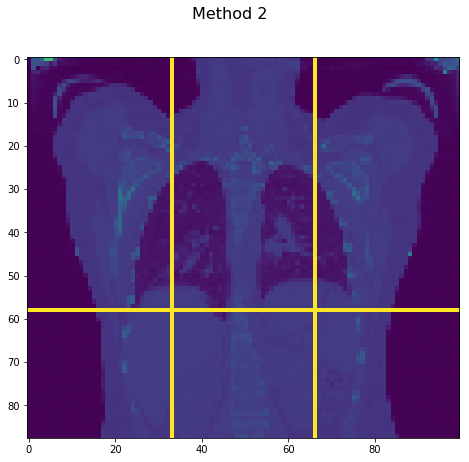

In [89]:
fig_3 = plt.figure(figsize=(15,7))  
ax = fig_3.subplots()
fig_3.suptitle("Method 2", fontsize=16)
plt.axis('off')
ax = plt.imshow(interval[:, seed_initial[1],:],cmap=plt.cm.gray)#por em gray, sem eixos
#circle_img = print_circle(img,seed_initial,min_dist)
#plt.imshow(circle_img)
plt.show()

In [ ]:
patient_id = "54828475"#each_mask.split(" ", each_mask.count(each_mask))[0] 
slices= arrange_slices(slices_path,patient_id)
normalized_volume=normalization(slices)
normalized_array = np.array(normalized_volume)
volume_resampled, spacing = resample(normalized_array, slices, [5,5,5])
print(volume_resampled.shape)
seed_1 = [0,0,0]
seed_thresh = 20
while seed_1 == [0,0,0]:
    seed_1, seed_2 = find_seed(volume_resampled,seed_thresh,'left')
    if seed_1 == [0,0,0]:
        seed_thresh= seed_thresh+15
        seed_1,seed_2 = find_seed(volume_resampled,seed_thresh,'left')
seeds = [seed_1]
#seed = find_seed(volume_resampled, 50,"right")
#pre_seed = tuple(seed)
thresh = 225
seg, counter = grow(volume_resampled,seed_1,thresh,1,seg)

In [ ]:
for i in range(130):
    fig, ax = plt.subplots()
    cs = ax.imshow(seg[:,i,:])
    plt.show()
    print(i)
    time.sleep(1)